In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random

In [3]:
words = open('../data/names.txt', 'r').read().splitlines()

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi['.'] = 0
itoch = {i:ch for ch, i in chtoi.items()}
vocab_size = len(itoch)
print(itoch)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = chtoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xval, Yval = build_dataset(words[n1:n2])   # 10%
Xtest,  Ytest  = build_dataset(words[n2:])     # 10%

torch.Size([182535, 3]) torch.Size([182535])
torch.Size([22792, 3]) torch.Size([22792])
torch.Size([22819, 3]) torch.Size([22819])


In [15]:
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden))
    B1 = torch.randn(n_hidden)
    W2 = torch.randn((n_hidden, vocab_size)) 
    B2 = torch.randn(vocab_size)

    params = [C, W1, B1, W2, B2]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2


In [11]:
def train(n_iters, lr, lossi, batch_size=32):
    for i in range(n_iters):
        
        # creating mini batch
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass
        emb = C[Xb] # embed characters to vectors
        embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
        hpreact = embcat @ W1 + B1 # hidden layer pre-activation 
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Yb)

        params = [C, W1, B1, W2, B2]

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()

        #update params
        for p in params:
            p.data += -lr * p.grad 

        # track stats
        if i % 10_000 == 0: # print loss every 10k steps
            print(f'step {i:7d} of {n_iters:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item()) # keeping track of log10 of losses

    return lossi    

In [12]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [32]:
def sample(n_samples=20):
    for _ in range(20):
        out = []
        context = [0] * block_size # init context with all dots ...
        while True:
            emb = C[torch.tensor([context])] # (1, block_size, d)
            h = torch.tanh(emb.view(1, -1) @ W1 + B1)
            logits = h @ W2 + B2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print(''.join(itoch[i] for i in out))    

In [46]:
C, W1, B1, W2, B2 = init_params()

11897


In [47]:
lossi = []
lossi = train(n_iters=50_000, lossi=lossi, lr=0.1)

step       0 of   50000: 26.0871
step   10000 of   50000: 2.7375
step   20000 of   50000: 2.3294
step   30000 of   50000: 2.3164
step   40000 of   50000: 2.4084


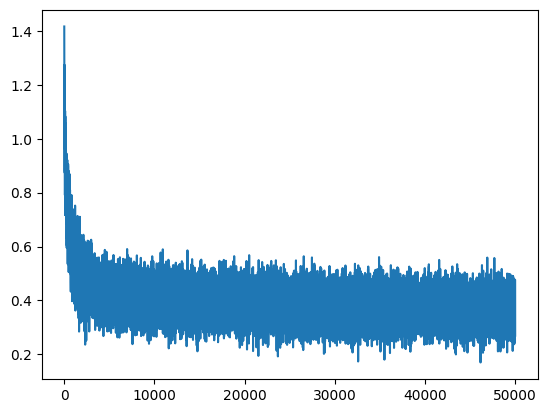

In [48]:
plt.plot(lossi)

In [50]:
split_loss('train')
split_loss('val')

train 2.381133556365967
val 2.424038887023926


In [51]:
sample()

emmeen.
ayaenni.
yani.
men.
caleiga.
amailo.
cayley.
finis.
amee.
gaeme.
fide.
noere.
aden.
ne.
nateste.
jazeellie.
vane.
lelu.
aagugneea.
kenn.


## Fixing Initialization Loss

Our initial loss is very high which then rapidly falls, this shows that the initialization isn't proper because the loss is too high. When training Neural Nets we almost always have some idea of what loss to expect at initialization.

At initialization, all characters have the same probability i.e. the probability distribution is uniform across all characters.

In [55]:
# prob for any character will be
p = torch.tensor(1 / 27.0)
loss  = -p.log()
loss

tensor(3.2958)

The initial loss expected is 3.29 which is much lower than what our first iteration has. The reason is at initialization the network is creating a random probability distribution in which some characters are very confident and some aren't which leads to the network being very confidently wrong.

In [93]:
# updating init function
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden))
    B1 = torch.randn(n_hidden)
    W2 = torch.randn((n_hidden, vocab_size)) * 0.01 
    B2 = torch.randn(vocab_size) * 0

    params = [C, W1, B1, W2, B2]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2

- We have updated `B2` to be 0 because in order to bring them as close as possible to 0, we don't want to add anything to the `logits` initially.
- We have added a scale down factor of 0.01 to `W2` for the same reason that we don't want our initial values to multiply with high random numbers.

Training with our updated initialization:

In [94]:
C, W1, B1, W2, B2 = init_params()
lossi = []
lossi = train(n_iters=100_000, lossi=lossi, lr=0.1)
split_loss('train')
split_loss('val')

11897
step       0 of  100000: 3.3406
step   10000 of  100000: 2.3823
step   20000 of  100000: 2.6873
step   30000 of  100000: 2.8254
step   40000 of  100000: 2.7461
step   50000 of  100000: 2.2923
step   60000 of  100000: 2.3396
step   70000 of  100000: 2.4500
step   80000 of  100000: 1.8712
step   90000 of  100000: 2.1205
train 2.1837990283966064
val 2.259556770324707


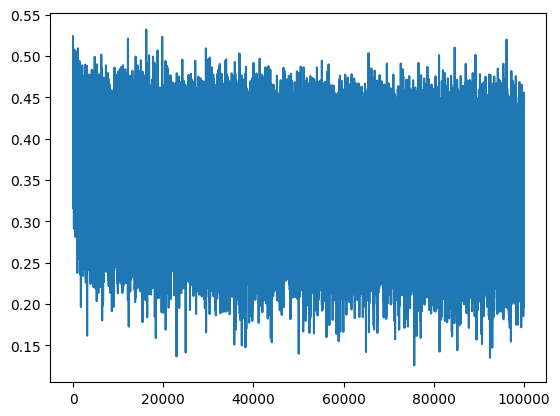

In [95]:
plt.plot(lossi)

Our initial loss has become very close to what we expect which can be seen in our plot of the loss which doesn't have the hockey shape appearance anymore.

Because of a better initialization the network has more cycles to actually optimize itself actually instead of spending the first few iteration to just squash the weights to bring them down from high random values.

## Fixing `tanh` Saturation

In [96]:
ix = torch.randint(0, Xtr.shape[0], (32, ))
Xb = Xtr[ix]
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1) 
hpreact = embcat @ W1 + B1 
h = torch.tanh(hpreact) 
h

tensor([[ 1.0000, -0.9994, -0.9371,  ..., -0.9320, -1.0000,  0.9996],
        [ 1.0000, -0.9990,  1.0000,  ..., -0.9170, -1.0000,  0.9990],
        [ 0.8968,  0.9235, -0.9867,  ..., -0.9997,  0.8858, -0.5534],
        ...,
        [-0.8467,  0.9962,  1.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.9817,  0.9954, -0.9979,  ..., -0.9985, -1.0000,  1.0000],
        [ 0.9947, -1.0000, -0.9999,  ..., -0.9927,  1.0000, -0.9999]],
       grad_fn=<TanhBackward0>)

Notice that a lot of values in `h` are 1 or -1. The `torch.tanh` function is a squash function and squashed the values smoothly between -1 and 1. Let's take a look at the histogram of `h`.

In [97]:
h.shape

torch.Size([32, 200])

In [98]:
# stretch h into 1 large vector
h.view(-1).shape

torch.Size([6400])

In [99]:
# convert it into a list
h_list = h.view(-1).tolist()
h_list[:10]

[0.9999740123748779,
 -0.9993640184402466,
 -0.937055766582489,
 0.9008157849311829,
 -0.40095168352127075,
 -0.9949542284011841,
 0.9999987483024597,
 -0.9998396635055542,
 -0.9994168877601624,
 0.9999866485595703]

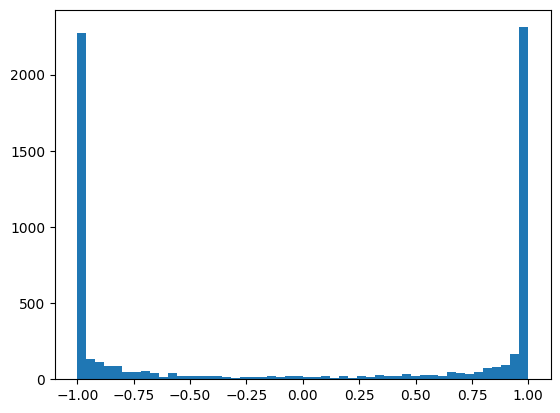

In [100]:
# draw histogram
plt.hist(h_list, 50); # semi colon to suppress output

We can confirm from the graph that most of the values are -1 and 1 which makes the `tanh` very active. 

Now let's look at the pre-activations that feed into the `tanh`.

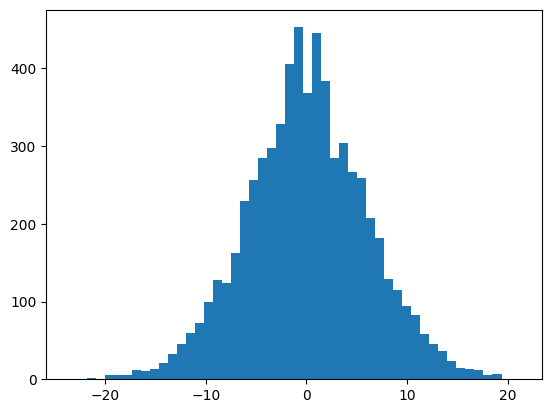

In [101]:
plt.hist(hpreact.view(-1).tolist(), 50);

Notice that the distribution of the preactivations is very broad, the numbers range from appx -25 to 25. This is the reason we have lots of -1 and 1 after we take `tanh` of these values.

### Why Is That An Issue For Backprop

When we perform backpropagation we also pass through our `tanh` layer which implements an element-wise `tanh`. The backward pass on the `tanh` layer is calculated as `self.grad += (1 - t**2) * out.grad` which means when the `tanh` of a value is 1 or -1 the gradient effectively becomes 0 i.e. we are stopping the backprop in this layer. The more closer the values are to -1 and 1, the more the gradient is squashed or destroyed.

Let's check how often `h` is in the flat regions of the `tanh` graph.

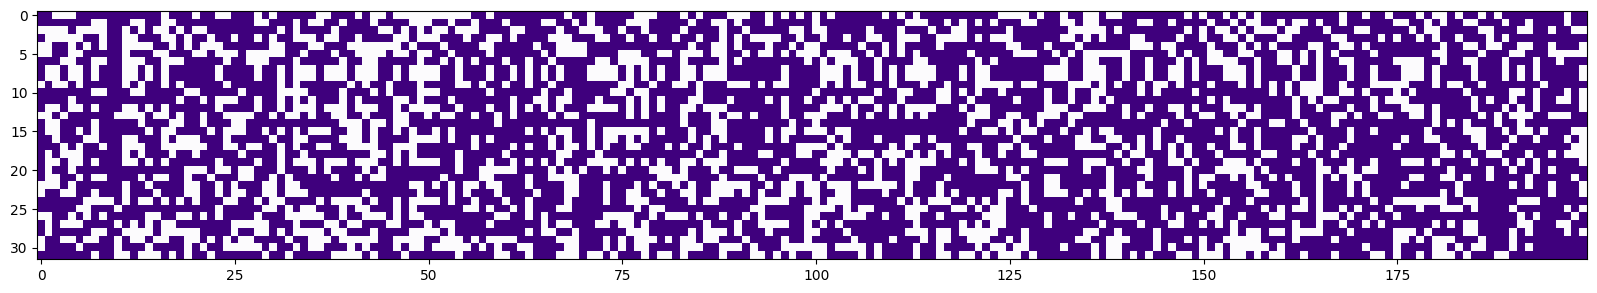

In [102]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='Purples', interpolation='nearest'); # purple if true, white if false

We can see that all the white marked neurons are in the flat tail of the `tanh` neuron and in all these cases the backward gradient will be destroyed.

**Dead Neuron**: If for any neuron in the above diagram the entire column is marked white then that neuron would be a dead neuron. That means no single example ever activates that neuron which means that neuron will never learn.

We have too many activations h that take on extreme values and the tanh neuron for that value lands in the flat region. This is not optimal and we don't want this specially during initialization because it means less training for neurons as they won't activate. It's happening because our h preactivation is too broad.

### Optimizing `hpreac`

In [103]:
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden)) * 0.1
    B1 = torch.randn(n_hidden) * 0.01
    W2 = torch.randn((n_hidden, vocab_size)) * 0.01 
    B2 = torch.randn(vocab_size) * 0

    params = [C, W1, B1, W2, B2]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2

Our forward pass looks like this: 

```
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1) 
hpreact = embcat @ W1 + B1 
h = torch.tanh(hpreact) 
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Yb)
```

We want `hpreact` to have values close to 0.

- So we scale down `B1` by factor of 0.01 to have a little bit of entropy at initialization.
- Scale down `W1` by factor of 0.1

In [104]:
C, W1, B1, W2, B2 = init_params()
lossi = []
lossi = train(n_iters=1, lossi=lossi, lr=0.1)
split_loss('train')
split_loss('val')

11897
step       0 of       1: 3.3174
train 3.2715229988098145
val 3.2720887660980225


Now let's take a look at the graphs.

In [106]:
ix = torch.randint(0, Xtr.shape[0], (32, ))
Xb = Xtr[ix]
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1) 
hpreact = embcat @ W1 + B1 
h = torch.tanh(hpreact) 

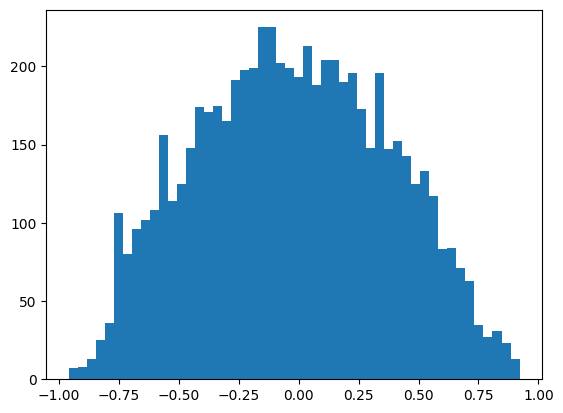

In [107]:
plt.hist(h.view(-1).tolist(), 50);

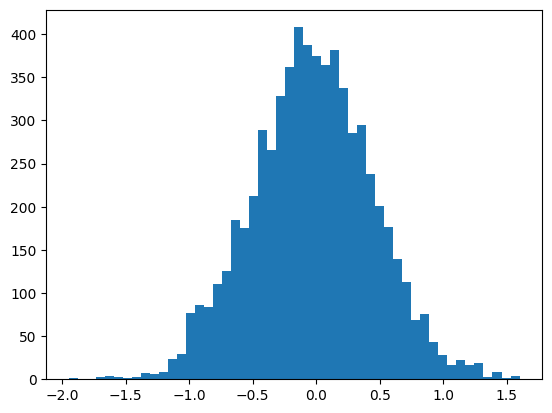

In [108]:
plt.hist(hpreact.view(-1).tolist(), 50);

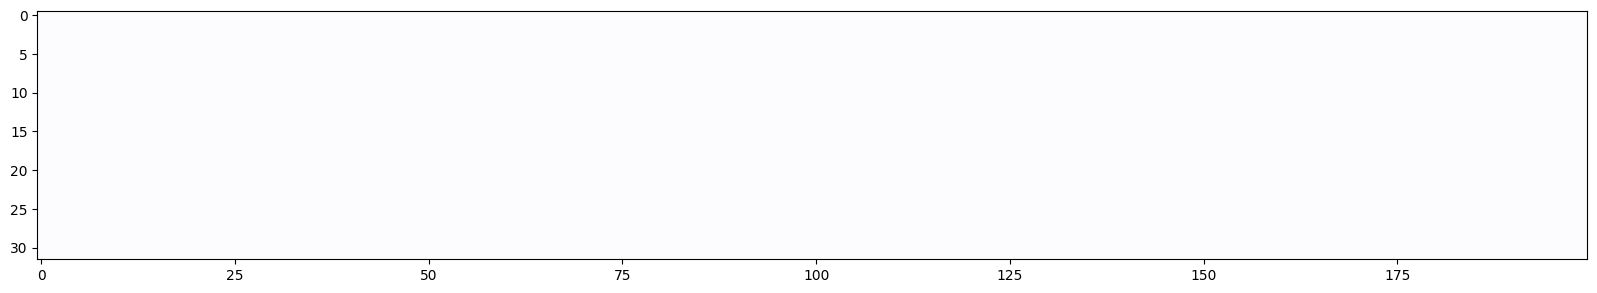

In [109]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='Purples', interpolation='nearest'); # purple if true, white if false

Now we have no values of `h.abs() > 0.99` which is a good place to be. Maybe we can have a little bit of saturation:

In [110]:
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden)) * 0.2
    B1 = torch.randn(n_hidden) * 0.01
    W2 = torch.randn((n_hidden, vocab_size)) * 0.01 
    B2 = torch.randn(vocab_size) * 0

    params = [C, W1, B1, W2, B2]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2

11897
step       0 of       1: 3.2918


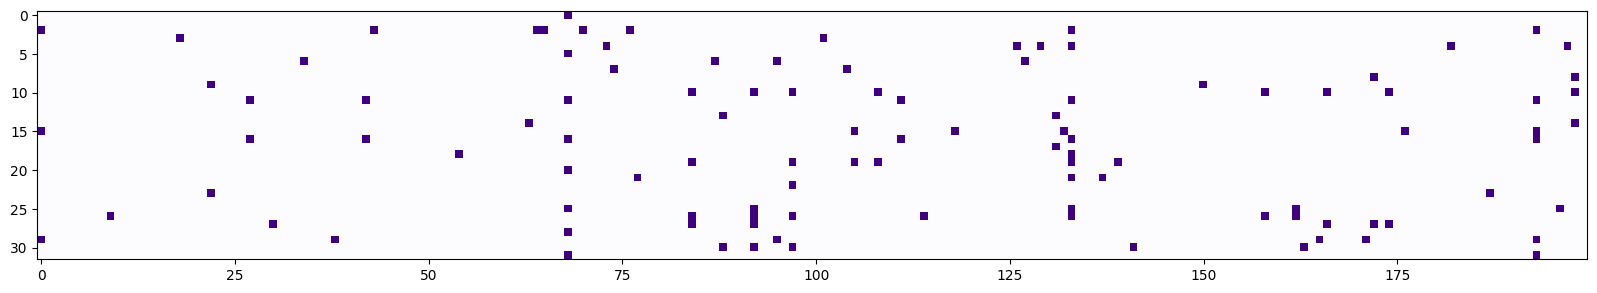

In [111]:
C, W1, B1, W2, B2 = init_params()
lossi = []
lossi = train(n_iters=1, lossi=lossi, lr=0.1)

ix = torch.randint(0, Xtr.shape[0], (32, ))
Xb = Xtr[ix]
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1) 
hpreact = embcat @ W1 + B1 
h = torch.tanh(hpreact) 

plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='Purples', interpolation='nearest'); # purple if true, white if false

So upon running the full optimization with the new initialization we get an improved loss:

In [112]:
C, W1, B1, W2, B2 = init_params()
lossi = []
lossi = train(n_iters=100_000, lossi=lossi, lr=0.1)
split_loss('train')
split_loss('val')

11897
step       0 of  100000: 3.2945
step   10000 of  100000: 2.4178
step   20000 of  100000: 1.9584
step   30000 of  100000: 2.3261
step   40000 of  100000: 2.2434
step   50000 of  100000: 2.4012
step   60000 of  100000: 2.2592
step   70000 of  100000: 1.8956
step   80000 of  100000: 1.9153
step   90000 of  100000: 1.8692
train 2.1377060413360596
val 2.207058906555176


## Calculating The Init Scale: Kaiming Init

tensor(-0.0066) tensor(0.9983)
tensor(-0.0004) tensor(3.1989)


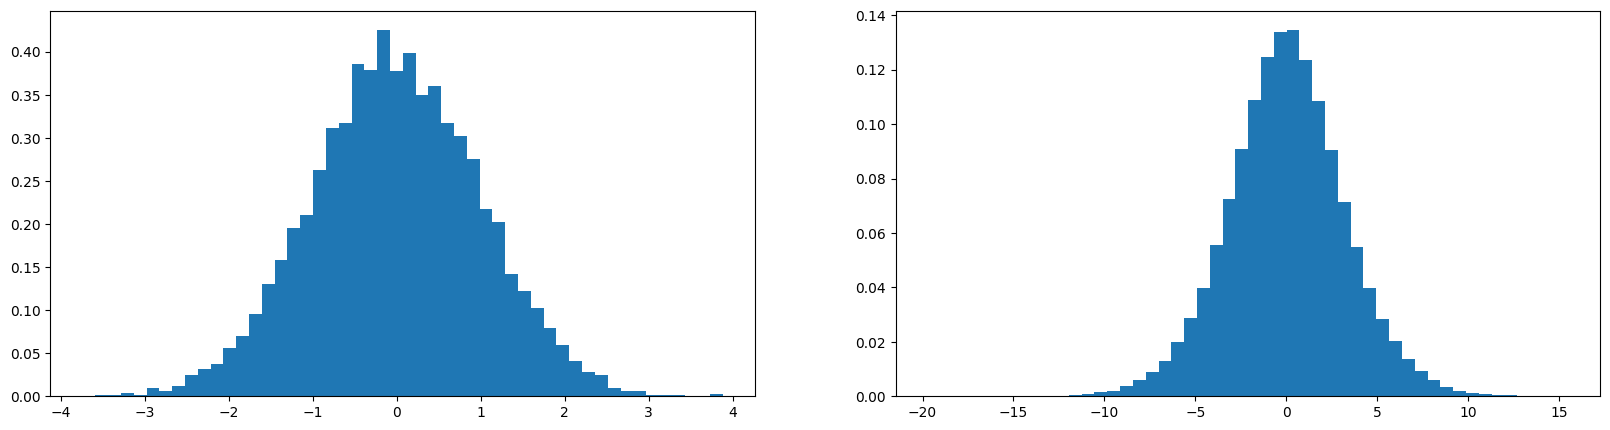

In [4]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

From the above figure and from the `mean` and `std` values can observe that when we perform the matmul opetation the mean of y remains 1 just like x but the deviation expands from the input. The Gaussian has expanded from the input which we don't want. We want most of the NNs to have relatively similar activations i.e. roughly unit gaussian throughout the neural net. 

How do we do that?

- When we scale up W then std deviation increases i.e. the gaussian expands and when we scale it down it comes closer i.e. the standard deviation decreases. So the task is to find that multiplication factor that preserves the std deviation to be 1.

The answer is to divide it by the square root of the fan-in i.e. the number of input elements.

tensor(-0.0015) tensor(0.9959)
tensor(-0.0021) tensor(0.9805)


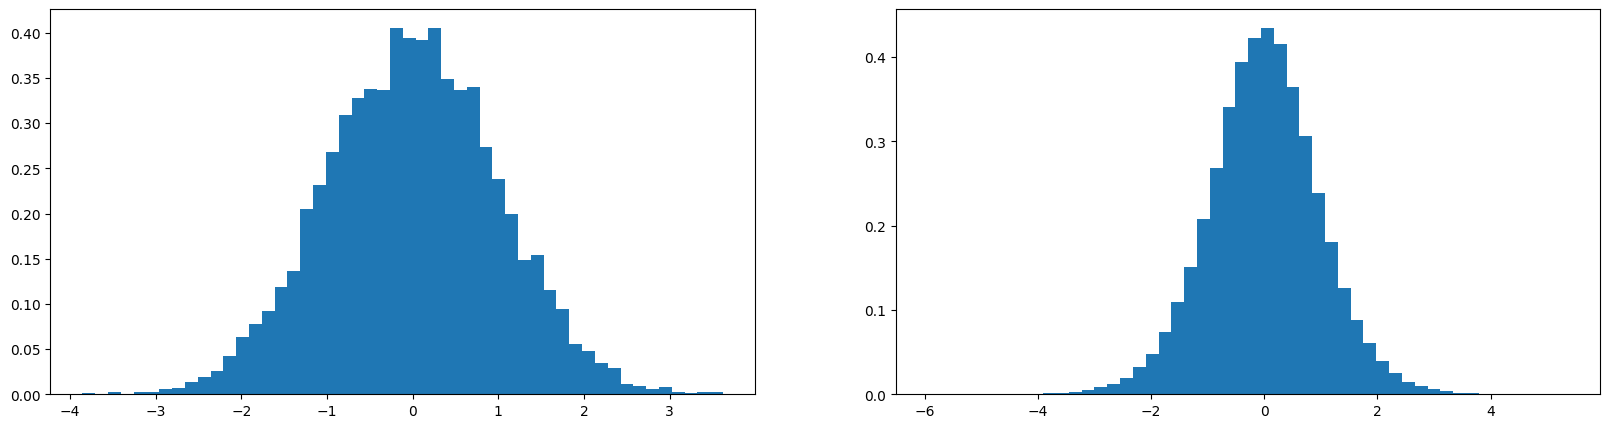

In [5]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

### Kaiming Normal 

Kaiming normal tells us that this multiplication factor should be `gain / sqrt(fan_mode)`. Where gain depends on the activation function that we use (for `tanh` is 5/3) and `fan_mode` is either `fan_in` or `fan_out` depending on whether we want unit std deviation for the weights or the gradients.

In [6]:
# updating the std deviation
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden)) * (5/3)/((n_embed * block_size)**0.5)
    B1 = torch.randn(n_hidden) * 0.01
    W2 = torch.randn((n_hidden, vocab_size)) * 0.01 
    B2 = torch.randn(vocab_size) * 0

    params = [C, W1, B1, W2, B2]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2

In [13]:
C, W1, B1, W2, B2 = init_params()
lossi = []
lossi = train(n_iters=100_000, lossi=lossi, lr=0.1)
split_loss('train')
split_loss('val')

11897
step       0 of  100000: 3.2696
step   10000 of  100000: 2.1048
step   20000 of  100000: 2.5525
step   30000 of  100000: 2.2773
step   40000 of  100000: 1.7125
step   50000 of  100000: 1.9453
step   60000 of  100000: 1.8863
step   70000 of  100000: 1.8922
step   80000 of  100000: 1.9982
step   90000 of  100000: 2.2038
train 2.1351826190948486
val 2.2027487754821777


We get to appx. the same loss as before when multiplied `W1` with 0.2 which we got by experimenting. This is because our scaling factor is 0.3 for this case which is close to 0.2. Key thing here is now we have a way to obtain this factor instead of just guessing.

### Note

The precise setting of these initializations is not as important for networks anymore because of modern innovation that make things significantly more stable like:

- Residual Connections
- Normalization layers like Batch norm, Layer norm, Group norm etc.
- Better optimizers like `adamw` etc.

## Batch Normalization

We want our hidden states to have roughly a Gaussian distribution so that our activation function `tanh` can perform better. Batch norm normalizes the activations to be Gaussian.

In [37]:
# our h preact is
ix = torch.randint(0, Xtr.shape[0], (32, ))
Xb = Xtr[ix]
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1) 
hpreact = embcat @ W1 + B1 
h = torch.tanh(hpreact)

hpreact.shape

torch.Size([32, 200])

In [18]:
hpreact.mean(0, keepdim=True).shape # mean over all elements in a batch

torch.Size([1, 200])

In [19]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

We normalize by subtracting the mean and dividing by the variance.

In [21]:
def train(n_iters, lr, lossi, batch_size=32):
    for i in range(n_iters):
        
        # creating mini batch
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass
        emb = C[Xb] # embed characters to vectors
        embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
        hpreact = embcat @ W1 + B1 # hidden layer pre-activation 
        hpreact =  (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # batch norm
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Yb)

        params = [C, W1, B1, W2, B2]

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()

        #update params
        for p in params:
            p.data += -lr * p.grad 

        # track stats
        if i % 10_000 == 0: # print loss every 10k steps
            print(f'step {i:7d} of {n_iters:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item()) # keeping track of log10 of losses

    return lossi    

So now the firing rate of every single neuron now will be exactly unit Gaussian for that batch.

When we train we won't see a great result because we want the activations to be roughly Gaussian only at initalization, we don't want them to be forced to be always Gaussian. We want the network to be able to modify the distribution to make some neurons more active than others depending on the results from backprop. 

So in addition to this operation we also have to introduce another component called scale and shift. We take the normalized inputs and scale them by some gain and offset them by some bias to get the final output.

In [38]:
# updating the std deviation
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden)) * (5/3)/((n_embed * block_size)**0.5)
    B1 = torch.randn(n_hidden) * 0.01
    W2 = torch.randn((n_hidden, vocab_size)) * 0.01 
    B2 = torch.randn(vocab_size) * 0

    b_norm_gain = torch.ones((1, n_hidden))
    b_norm_bias = torch.zeros((1, n_hidden))

    params = [C, W1, B1, W2, B2, b_norm_gain, b_norm_bias]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2, b_norm_gain, b_norm_bias

In [39]:
def train(n_iters, lr, lossi, b_norm_gain, b_norm_bias, batch_size=32, n_hidden=200):
    for i in range(n_iters):
        
        # creating mini batch
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass
        emb = C[Xb] # embed characters to vectors
        embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
        hpreact = embcat @ W1 + B1 # hidden layer pre-activation 
        hpreact = b_norm_gain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + b_norm_bias # batch norm
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Yb)

        params = [C, W1, B1, W2, B2, b_norm_gain, b_norm_bias]

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()

        #update params
        for p in params:
            p.data += -lr * p.grad 

        # track stats
        if i % 10_000 == 0: # print loss every 10k steps
            print(f'step {i:7d} of {n_iters:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item()) # keeping track of log10 of losses

    return lossi    

At initialization `b_norm_gain` is set to 1 and `b_norm_bias` is set to zero so for this batch each neuron's firing batch will be exactly unit Gaussian.

In [40]:
@torch.no_grad()
def split_loss(split, b_norm_gain, b_norm_bias):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + B1
    hpreact = b_norm_gain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + b_norm_bias
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

During optimization the network will be able to backpropagate and modify `b_norm_gain` and `b_norm_bias` to be able to modify the activations in order to optimize the itself.

In [41]:
C, W1, B1, W2, B2, b_n_gain, b_n_bias = init_params()
lossi = []
lossi = train(n_iters=100_000, lossi=lossi, lr=0.1, b_norm_gain=b_n_gain, b_norm_bias=b_n_bias)
split_loss('train', b_norm_gain=b_n_gain, b_norm_bias=b_n_bias)
split_loss('val', b_norm_gain=b_n_gain, b_norm_bias=b_n_bias)

12297
step       0 of  100000: 3.3116
step   10000 of  100000: 2.6084
step   20000 of  100000: 2.1453
step   30000 of  100000: 2.0826
step   40000 of  100000: 2.5694
step   50000 of  100000: 2.1861
step   60000 of  100000: 2.4141
step   70000 of  100000: 2.1203
step   80000 of  100000: 2.1794
step   90000 of  100000: 2.1055
train 2.143097400665283
val 2.179856061935425


The improvement wasn't very significant in this case because our network only has a single hidden layer. In case of deeper neural nets that have a number of different types of operations, it'll become very difficult to optimize the initial scaling to make activations roughly Gaussian. It'll become much easier to add batch norm layers instead. So it's customary to append a batch norm layer to a linear layer to control the scale of the activations.

### Cost Of Batch Norm

Earlier we had a single example feeding into the NN and we calculated it's activations and it's logits which was a deterministic process for a set of examples. To make this process more efficient we started processing these examples in parallel using batches. Now because of Batch norm we are coupling these examples mathematically so now the `hpreact` and `logits` for any particular example are not just a function of that example but they're also a function of all the other examples in that batch. 

Surprisingly this is not a bug. This side effect turns out to be beneficial while training a network because it acts like a regulaizer because it adds a bitter of a jitter to the input which makes it harder for the network to overfit.

### Another Caveat

When we deploy our model, it'll make predictions based on a single input but because of the coupling introduced by batch norm it expects a batch as an input. How do we get around this? 

There needs to be a step after training that calculates and sets the batch norm mean and std at once over the training set.

In [42]:
# calibrate batch norm at the end of training 
@torch.no_grad()
def calibrate_batch_norm():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + B1 
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

    return bnmean, bnstd

In [44]:
# use this calibration while calculating loss
@torch.no_grad()
def split_loss(split, b_norm_gain, b_norm_bias, bnmean, bnstd):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + B1
    hpreact = b_norm_gain * (hpreact - bnmean) / bnstd + b_norm_bias
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

Because the mean and std deviation are now fixed, we can forward a single example.

In [45]:
bnmean, bnstd = calibrate_batch_norm()
split_loss('train', b_norm_gain=b_n_gain, b_norm_bias=b_n_bias, bnmean=bnmean, bnstd=bnstd)
split_loss('val', b_norm_gain=b_n_gain, b_norm_bias=b_n_bias, bnmean=bnmean, bnstd=bnstd)

train 2.143097400665283
val 2.1798863410949707


We don't want to keep calculating `bnmean` and `bnstd` as a second stage after NN training. We can estimate these values in a running manner during training of the network and simply have a single stage of training.

In [47]:
# updating the std deviation
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden)) * (5/3)/((n_embed * block_size)**0.5)
    B1 = torch.randn(n_hidden) * 0.01
    W2 = torch.randn((n_hidden, vocab_size)) * 0.01 
    B2 = torch.randn(vocab_size) * 0

    b_norm_gain = torch.ones((1, n_hidden))
    b_norm_bias = torch.zeros((1, n_hidden))
    bnmean_running = torch.zeros((1, n_hidden)) # mean will be zero at init
    bnstd_running = torch.ones((1, n_hidden)) # std dev 1 at init

    params = [C, W1, B1, W2, B2, b_norm_gain, b_norm_bias]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2, b_norm_gain, b_norm_bias, bnmean_running, bnstd_running

In [51]:
def train(n_iters, lr, lossi, b_norm_gain, b_norm_bias, bnmean_running, bnstd_running, batch_size=32, n_hidden=200):
    for i in range(n_iters):
        
        # creating mini batch
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass
        emb = C[Xb] # embed characters to vectors
        embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
        hpreact = embcat @ W1 + B1 # hidden layer pre-activation 
        bnmeani = hpreact.mean(0, keepdim=True)
        bnstdi = hpreact.std(0, keepdim=True)
        hpreact = b_norm_gain * (hpreact - bnmeani) / bnstdi + b_norm_bias # batch norm

        # we don't derive gradients for bnmean and bnstd
        # they are updated on the side of training
        with torch.no_grad():
            bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
            bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Yb)

        params = [C, W1, B1, W2, B2, b_norm_gain, b_norm_bias]

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()

        #update params
        for p in params:
            p.data += -lr * p.grad 

        # track stats
        if i % 10_000 == 0: # print loss every 10k steps
            print(f'step {i:7d} of {n_iters:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item()) # keeping track of log10 of losses

    return lossi, bnmean_running, bnstd_running    

In [52]:
C, W1, B1, W2, B2, b_n_gain, b_n_bias, bnmean_running, bnstd_running = init_params()
lossi = []
lossi, bnmean_running, bnstd_running = train(n_iters=100_000, lossi=lossi, lr=0.1, b_norm_gain=b_n_gain, b_norm_bias=b_n_bias, bnmean_running=bnmean_running, bnstd_running=bnstd_running)

12297
step       0 of  100000: 3.3145
step   10000 of  100000: 2.0440
step   20000 of  100000: 1.8335
step   30000 of  100000: 2.0630
step   40000 of  100000: 2.0934
step   50000 of  100000: 1.8726
step   60000 of  100000: 2.0273
step   70000 of  100000: 2.0472
step   80000 of  100000: 2.2329
step   90000 of  100000: 2.2412


In [57]:
@torch.no_grad()
def split_loss(split, b_norm_gain, b_norm_bias, bnmean_running, bnstd_running):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + B1
    hpreact = b_norm_gain * (hpreact - bnmean_running) / bnstd_running + b_norm_bias
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [58]:
split_loss('train', b_norm_gain=b_n_gain, b_norm_bias=b_n_bias, bnmean_running=bnmean_running, bnstd_running=bnstd_running)
split_loss('val', b_norm_gain=b_n_gain, b_norm_bias=b_n_bias, bnmean_running=bnmean_running, bnstd_running=bnstd_running)

train 2.1370203495025635
val 2.1807944774627686


We have now eliminated the need for explicit calculation of `bnmean` and `bnstd`.

Notice that while calculating `hpreact` we are adding biased `B1`. We then calculate their mean and subtract them. So biases `B1` get effectively eliminated and have no effect. So whenever we have a Batch norm layer and have a weight layer before it we don't need to have any biases for it instead we have a bnbias which provides the necessary biases. The Batch norm layer has it's own bais. So add this update we have:

In [66]:
# updating the std deviation
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden)) * (5/3)/((n_embed * block_size)**0.5)
    W2 = torch.randn((n_hidden, vocab_size)) * 0.01 
    B2 = torch.randn(vocab_size) * 0

    b_norm_gain = torch.ones((1, n_hidden))
    b_norm_bias = torch.zeros((1, n_hidden))
    bnmean_running = torch.zeros((1, n_hidden)) # mean will be zero at init
    bnstd_running = torch.ones((1, n_hidden)) # std dev 1 at init

    params = [C, W1, W2, B2, b_norm_gain, b_norm_bias]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, W2, B2, b_norm_gain, b_norm_bias, bnmean_running, bnstd_running

In [67]:
def train(n_iters, lr, lossi, b_norm_gain, b_norm_bias, bnmean_running, bnstd_running, batch_size=32, n_hidden=200):
    for i in range(n_iters):
        
        # creating mini batch
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass
        
        emb = C[Xb] # embed characters to vectors
        embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
        
        # linear layer
        hpreact = embcat @ W1
        
        # batch norm layer
        bnmeani = hpreact.mean(0, keepdim=True)
        bnstdi = hpreact.std(0, keepdim=True)
        hpreact = b_norm_gain * (hpreact - bnmeani) / bnstdi + b_norm_bias # batch norm
        # we don't derive gradients for bnmean and bnstd
        # they are updated on the side of training
        with torch.no_grad():
            bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
            bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

        # non linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Yb)

        params = [C, W1, W2, B2, b_norm_gain, b_norm_bias]

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()

        #update params
        for p in params:
            p.data += -lr * p.grad 

        # track stats
        if i % 10_000 == 0: # print loss every 10k steps
            print(f'step {i:7d} of {n_iters:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item()) # keeping track of log10 of losses

    return lossi, bnmean_running, bnstd_running    

In [68]:
C, W1, W2, B2, b_n_gain, b_n_bias, bnmean_running, bnstd_running = init_params()
lossi = []
lossi, bnmean_running, bnstd_running = train(n_iters=100_000, lossi=lossi, lr=0.1, b_norm_gain=b_n_gain, b_norm_bias=b_n_bias, bnmean_running=bnmean_running, bnstd_running=bnstd_running)
split_loss('train', b_norm_gain=b_n_gain, b_norm_bias=b_n_bias, bnmean_running=bnmean_running, bnstd_running=bnstd_running)
split_loss('val', b_norm_gain=b_n_gain, b_norm_bias=b_n_bias, bnmean_running=bnmean_running, bnstd_running=bnstd_running)

12097
step       0 of  100000: 3.3084
step   10000 of  100000: 1.9958
step   20000 of  100000: 2.0704
step   30000 of  100000: 2.1410
step   40000 of  100000: 2.0739
step   50000 of  100000: 2.0965
step   60000 of  100000: 1.8571
step   70000 of  100000: 2.0170
step   80000 of  100000: 2.5511
step   90000 of  100000: 2.2461
train 2.1484267711639404
val 2.189937114715576


## Pytorch-like Code For Our Training Process

In [8]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [9]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers trained with running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # eps is added in denom to prevent div with 0 
        self.out = self.gamma * xhat + self.beta

        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]        

In [10]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

Training using our layers defined above:

In [22]:
n_embed = 10
n_hidden = 100

C = torch.randn(vocab_size, n_embed)

layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # make last layer less confident at init
    layers[-1].weight *= 0.1
    # apply gain to all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [23]:
n_iters = 200_000
batch_size = 32
lossi = []
ud = [] # update to data ratio

for i in range(n_iters):

    # mini batch const.
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # keeping this for debugging only
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # lr decay
    for p in parameters:
        p.data += -lr * p.grad # lr * grad = update

    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{n_iters:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # std dev of update / dev of actual data of params

    if i >= 1000:
        break # take this out after debugging to run full optimization    


      0/ 200000: 3.2952


## Vistualizing Activations

We'll visualize the forward pass activations at the `tanh` layers.

layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 19.81%
layer 3 (      Tanh): mean +0.02, std 0.71, saturated: 12.19%
layer 5 (      Tanh): mean +0.00, std 0.71, saturated: 10.94%
layer 7 (      Tanh): mean +0.00, std 0.73, saturated: 12.19%
layer 9 (      Tanh): mean +0.04, std 0.72, saturated: 11.41%


Text(0.5, 1.0, 'activation distribution')

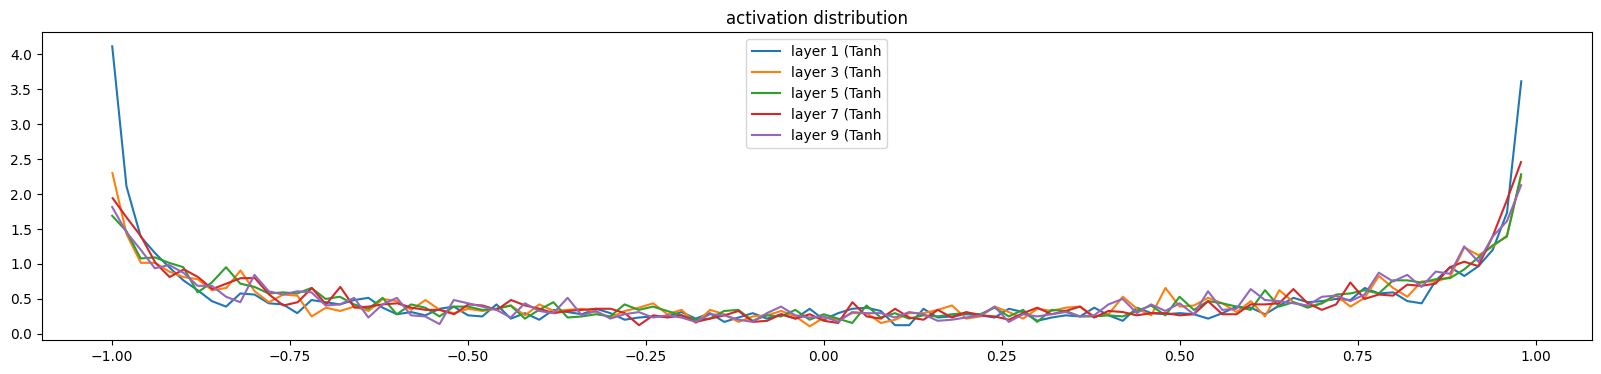

In [24]:
# for activations
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000100, std 3.402912e-03
layer 3 (      Tanh): mean +0.000021, std 3.029836e-03
layer 5 (      Tanh): mean +0.000046, std 2.952767e-03
layer 7 (      Tanh): mean -0.000115, std 2.787199e-03
layer 9 (      Tanh): mean +0.000042, std 2.357584e-03


Text(0.5, 1.0, 'gradient distribution')

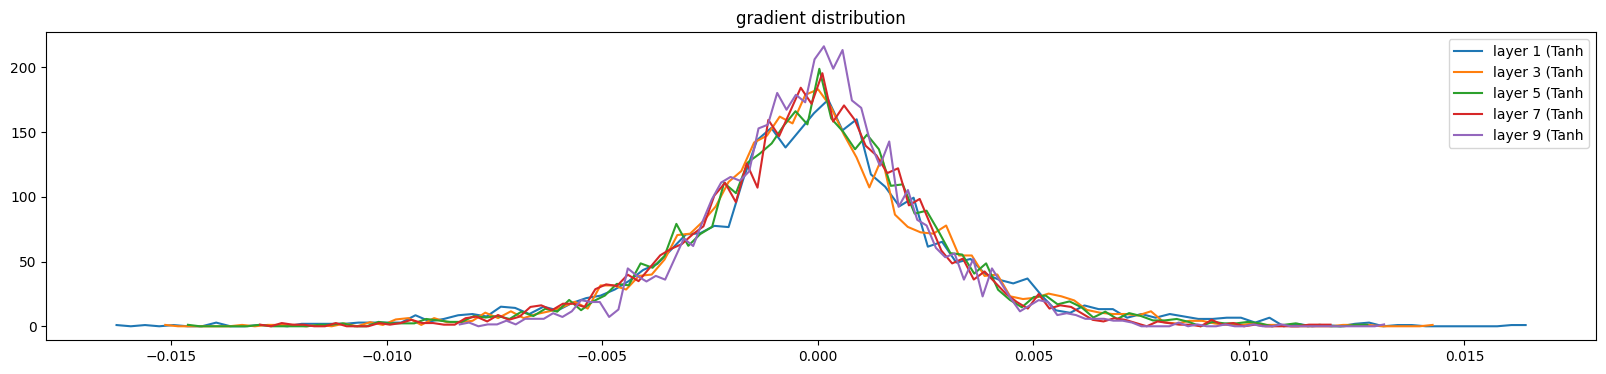

In [25]:
# for gradients
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000562 | std 1.199808e-02 | grad:data ratio 1.161192e-02
weight  (30, 100) | mean -0.000219 | std 1.032882e-02 | grad:data ratio 3.398059e-02
weight (100, 100) | mean +0.000084 | std 8.098290e-03 | grad:data ratio 4.818330e-02
weight (100, 100) | mean +0.000031 | std 7.147865e-03 | grad:data ratio 4.248486e-02
weight (100, 100) | mean -0.000008 | std 7.026712e-03 | grad:data ratio 4.154003e-02
weight (100, 100) | mean +0.000071 | std 6.002195e-03 | grad:data ratio 3.576154e-02
weight  (100, 27) | mean +0.000000 | std 2.780334e-02 | grad:data ratio 3.994074e-01


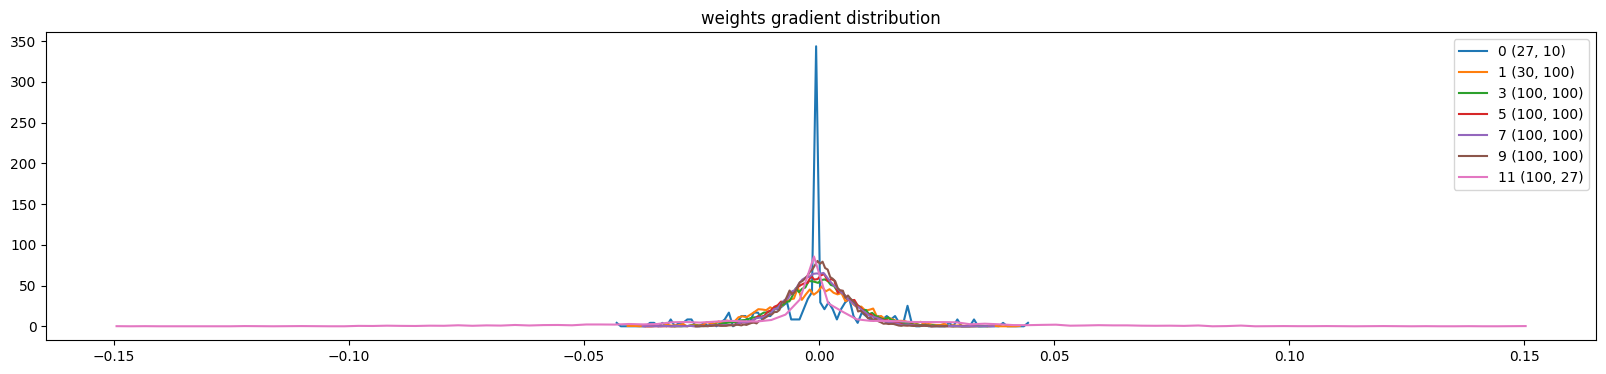

In [26]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

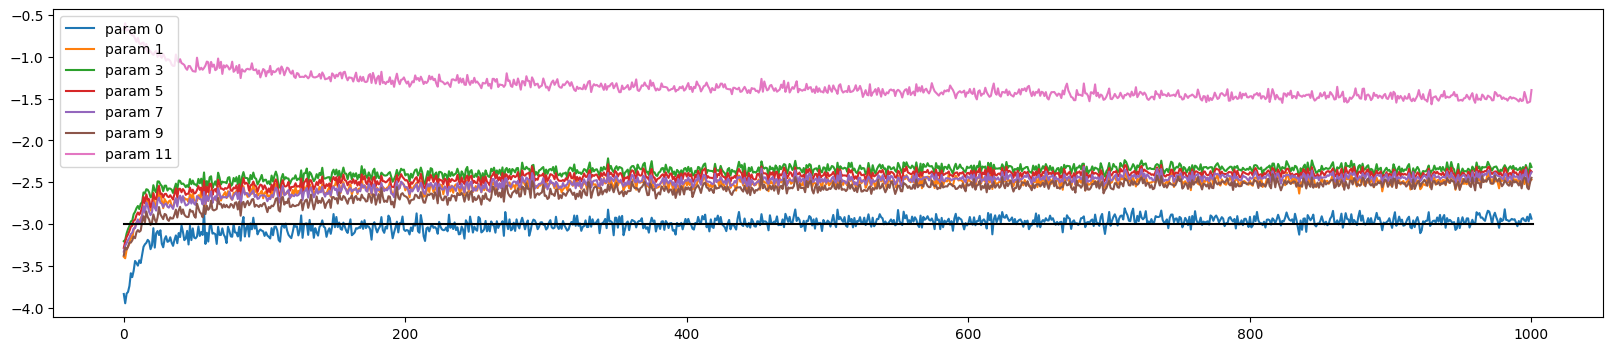

In [27]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


## Adding Batch Norm Layer

In [17]:
n_embed = 10
n_hidden = 100

C = torch.randn(vocab_size, n_embed)

layers = [
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # make last layer less confident at init
    # layers[-1].weight *= 0.1 
    layers[-1].gamma *= 0.1 # changing gamma instead of weight because last layer is batch norm
    # apply gain to all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47024


In [18]:
n_iters = 200_000
batch_size = 32
lossi = []
ud = [] # update to data ratio

for i in range(n_iters):

    # mini batch const.
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # keeping this for debugging only
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # lr decay
    for p in parameters:
        p.data += -lr * p.grad # lr * grad = update

    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{n_iters:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # std dev of update / dev of actual data of params

    if i >= 1000:
        break # take this out after debugging to run full optimization    

      0/ 200000: 3.2804


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.12%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.81%
layer 8 (      Tanh): mean +0.00, std 0.65, saturated: 2.56%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 2.09%


Text(0.5, 1.0, 'activation distribution')

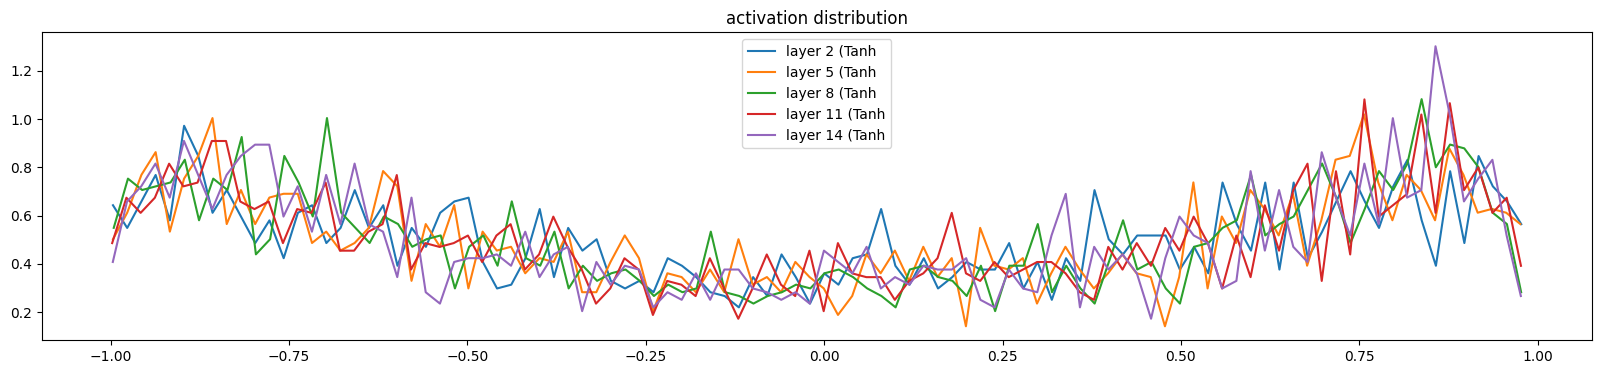

In [19]:
# for activations
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.410305e-03
layer 5 (      Tanh): mean +0.000000, std 2.898953e-03
layer 8 (      Tanh): mean -0.000000, std 2.776749e-03
layer 11 (      Tanh): mean -0.000000, std 2.706281e-03
layer 14 (      Tanh): mean -0.000000, std 2.506775e-03


Text(0.5, 1.0, 'gradient distribution')

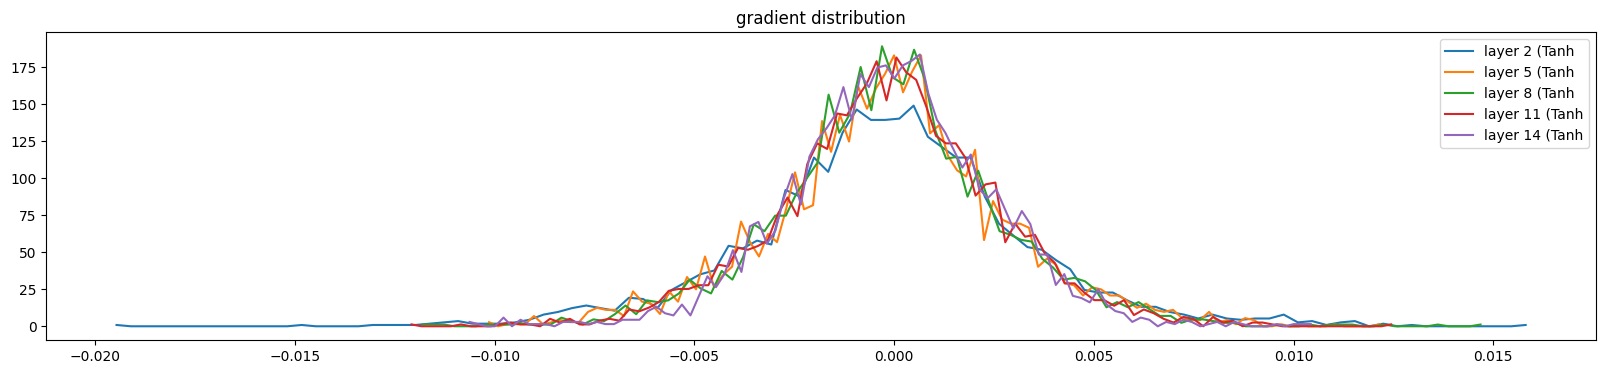

In [20]:
# for gradients
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.034950e-02 | grad:data ratio 9.733235e-03
weight  (30, 100) | mean -0.000014 | std 7.725030e-03 | grad:data ratio 2.530608e-02
weight (100, 100) | mean -0.000035 | std 6.192585e-03 | grad:data ratio 3.707195e-02
weight (100, 100) | mean +0.000023 | std 5.460041e-03 | grad:data ratio 3.253581e-02
weight (100, 100) | mean +0.000008 | std 5.260163e-03 | grad:data ratio 3.153906e-02
weight (100, 100) | mean -0.000028 | std 5.236812e-03 | grad:data ratio 3.125428e-02
weight  (100, 27) | mean -0.000149 | std 9.888116e-03 | grad:data ratio 5.912586e-02


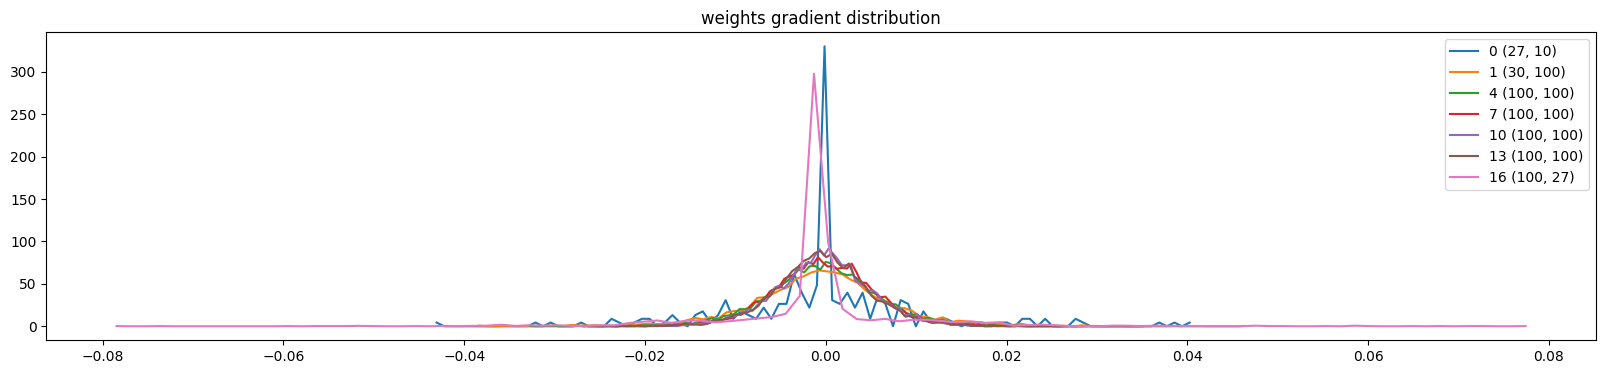

In [21]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

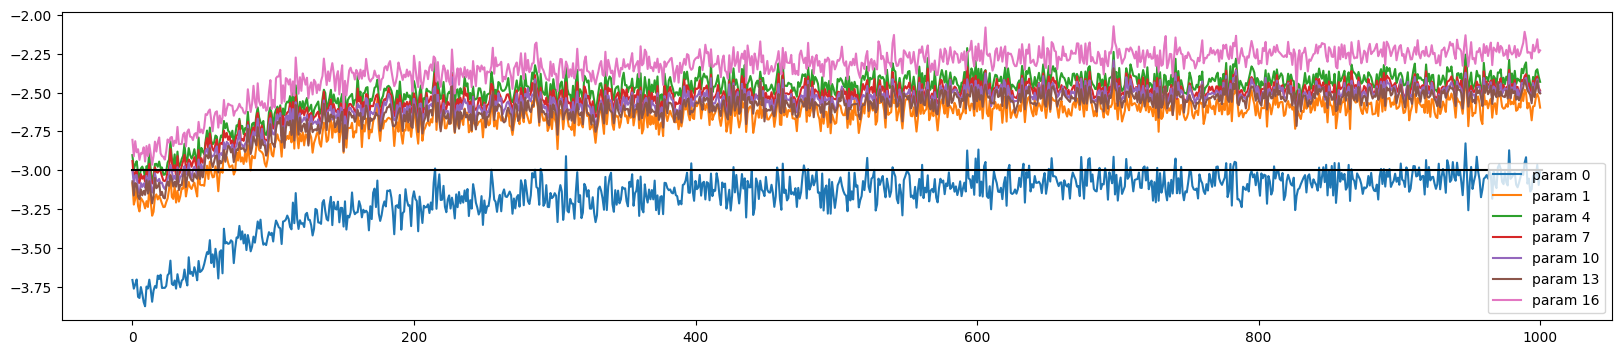

In [22]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
